# Cyclists Dataset Understanding

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In this notebook, we will analyze and understand the behavior and patterns of cyclists in a deeper way, after the first analysis about the syntactic and semantic correctness.

So, we will study in more detail the type of attributes, verifying how these types can be changed if they are not suitable for the domain of the attributes, also ensuring that the non-NaN values present in the dataset fall within their respective domains

By the end of this notebook, we aim to gain a comprehensive understanding of cyclists' activities and make data-driven decisions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.impute import KNNImputer
import random
import math
import seaborn as sb
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('../src'))

from utils import *

In [3]:
# Create union of two datasets, merging them considering the url of the cyclist
dataset_cyclists = pd.read_csv("../data/cyclists.csv")
dataset_races = pd.read_csv("../data/races.csv")
complete_data = pd.merge(dataset_cyclists, dataset_races, left_on='_url', right_on='cyclist', how='inner')

# Modify name column of the cyclist url in 'cyclist_url', and name column of the race url in 'race_url'
complete_data = complete_data.rename(columns={'_url_x': 'cyclist_url', '_url_y': 'race_url'})
# Modify name column of the cyclist name in 'cyclist_name', and name column of the race name in 'race_name'
complete_data = complete_data.rename(columns={'name_x': 'cyclist_name', 'name_y': 'race_name'})

# Take only the year-month-day part of 'date' (delete the time)
complete_data['date'] = complete_data['date'].str.split(' ').str[0]

races = pd.read_csv("../data/races.csv")

In [4]:
dataset = pd.read_csv("../data/cyclists.csv")
dataset.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


In [5]:
dataset.describe()

,birth_year,weight,height
count,6121.000000,3078.000000,3143.000000
mean,1974.071884,68.658739,179.815145
std,15.535834,6.348183,6.443447
min,1933.000000,48.000000,154.000000
25%,1962.000000,64.000000,175.000000
50%,1974.000000,69.000000,180.000000
75%,1987.000000,73.000000,184.000000
max,2004.000000,94.000000,204.000000


## Type Correctness
In this initial section we check the correctness of the data types

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


Considering all the type of the feature, the object attributes can stay as they are, and also the `height` and `weight` attributes can reasonably be considered as float values, while the `birth_year` attribute is logically an integer and so we change it. 

In [7]:
dataset['birth_year'] = dataset[dataset['birth_year'].notnull()]['birth_year'].astype(int)

In [8]:
print(f'Number of duplicates: {len(dataset)-len(dataset.drop_duplicates())}')

Number of duplicates: 0


## Features Understanding

The current section of the document will delve further into the examination of feature values.

In [9]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset) # compute the percentage of missing values
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})

missing_value_df['percent_missing']

_url            0.000000
name            0.000000
birth_year      0.211933
weight         49.820672
height         48.761004
nationality     0.016303
Name: percent_missing, dtype: float64

From this results, we see that just fews cyclists don't have the birth year or the nationality, and we aim to easily impute them. Instead, we see that almost half of the weight and height values are null, and we will see if we can impute them from each other.

### `_url` data

We identified 39 cyclists registered in the "cyclists.csv" dataset and absent in the "races.csv" dataset. We also confirmed that all cyclists registered in the "races.csv" dataset are present in the "cyclists.csv" dataset and that consequently, the additional data present in the latter are only an "extra" compared to otherwise consistent data between the two datasets.

In [10]:
dataset[~dataset['_url'].isin(races['cyclist'])]

,_url,name,birth_year,weight,height,nationality
578,jean-michel-thilloy,Jean-Michel Thilloy,1966.0,NaN,NaN,France
902,gert-van-brabant,Gert Van Brabant,1968.0,NaN,NaN,Belgium
1046,roman-bronis,Roman Broniš,1976.0,74.0,187.0,Slovakia
1176,oleg-grishkine,Oleg Grishkine,1975.0,NaN,NaN,Russia
1330,eddy-torrekens,Eddy Torrekens,1970.0,NaN,NaN,Belgium
1449,philipp-ludescher,Philipp Ludescher,1987.0,72.0,187.0,Austria
1486,nicolas-liboreau,Nicolas Liboreau,1977.0,NaN,NaN,France
1538,gino-primo,Gino Primo,1966.0,NaN,NaN,Belgium
1566,luca-braidot,Luca Braidot,1991.0,69.0,179.0,Italy
1718,tanner-putt,Tanner Putt,1992.0,75.0,178.0,United States


In [11]:
races[~races['cyclist'].isin(dataset['_url'])]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta


### `name` data

In [12]:
# TODO: rimuovere se non serve

### `birth_year` data 

Our idea is to attempt later a manual imputation of missing birth dates using data from the 'races.csv' dataset, and we check if it's possible.

Cyclists in the 'cyclist.csv' dataset with NaN ages do not have a non-NaN "birth_year" attribute in the 'races.csv' dataset. Because of this, we cannot use information from the second dataset to complete the first.

In [13]:
missing_birthyear = dataset[dataset['birth_year'].isnull()]['_url'].to_list()
tmp_df = races[races['cyclist'].isin(missing_birthyear)]
tmp_df[tmp_df['cyclist_age'].notnull()]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta


We tried to manually retrieve as much data as possible through online searches supported by direct comparisons with other data present in the 'races.csv' dataset.

Once a cyclist was identified with high probability, we manually imputed the obtained value into the corresponding 'birth_year' feature. Note that we will perform thisduring the data cleaning.

In [14]:
dataset.loc[dataset['_url'] == 'scott-davies', 'birth_year'] = 1995
dataset.loc[dataset['_url'] == 'vladimir-malakov', 'birth_year'] = 1958
dataset.loc[dataset['_url'] == 'antonio-zanini', 'birth_year'] = 1965
dataset.loc[dataset['_url'] == 'nevens-guy', 'birth_year'] = 1962
dataset.loc[dataset['_url'] == 'sergei-jermachenko', 'birth_year'] = 1956 

In [42]:
dataset['birth_year'] = dataset['birth_year'].fillna(dataset['birth_year'].mode()[0]) # substitue 8 remaining elements with mode

### `weight` and `height` data

Our initial hypothesis is that weight, height and nationality are correlated. We would like to use this information to perform proximity imputation on incomplete records.

To proceed with this strategy, it is essential to establish the actual correlations between these attributes (confirming or disproving the expected ones or discovering new ones).

Now we consider the `weight` and `height` columns together, and we check the combinations of null values

In [15]:
# Filter rows where 'weight' is null and 'height' is not null
missing_weight_with_height = dataset[dataset['weight'].isnull() & dataset['height'].notnull()]

print("Cyclists where we have only the height:", len(missing_weight_with_height))
missing_weight_with_height

Cyclists where we have only the height: 72


,_url,name,birth_year,weight,height,nationality
76,idar-andersen,Idar Andersen,1999.0,NaN,182.0,Norway
219,thomas-bonnet,Thomas Bonnet,1998.0,NaN,175.0,France
261,syver-waersted,Syver Wærsted,1996.0,NaN,193.0,Norway
355,loe-van-belle,Loe van Belle,2002.0,NaN,184.0,Netherlands
403,negasi-abreha,Negasi Haylu Abreha,2000.0,NaN,186.0,Ethiopia
...,...,...,...,...,...,...
5836,matheo-vercher,Mattéo Vercher,2001.0,NaN,171.0,France
6033,erik-nordsaeter-resell,Erik Nordsæter Resell,1996.0,NaN,192.0,Norway
6063,carlos-galarreta,Carlos Galarreta,1967.0,NaN,174.0,Spain
6088,eric-antonio-fagundez,Eric Antonio Fagúndez,1998.0,NaN,180.0,Uruguay


In [16]:
# Filter rows where 'weight' is not null and 'height' is null
missing_height_with_weight = dataset[dataset['weight'].notnull() & dataset['height'].isnull()]

print("Cyclists where we have only the weight:", len(missing_height_with_weight))
missing_height_with_weight

Cyclists where we have only the weight: 7


,_url,name,birth_year,weight,height,nationality
114,mario-de-sarraga,Mario de Sárraga,1980.0,69.0,NaN,Spain
687,frank-hoste,Frank Hoste,1955.0,76.0,NaN,Belgium
1017,davide-orrico,Davide Orrico,1990.0,70.0,NaN,Italy
1651,nicolas-dalla-valle,Nicolas Dalla Valle,1997.0,73.0,NaN,Italy
3161,nils-brun,Nils Brun,2000.0,64.0,NaN,Switzerland
5652,yannis-voisard,Yannis Voisard,1998.0,56.0,NaN,Switzerland
5755,jean-nuttli,Jean Nüttli,1974.0,70.0,NaN,Switzerland


In [17]:
# Filter rows where both 'weight' and 'height' are null
missing_weight_missing_height = dataset[dataset['weight'].isnull() & dataset['height'].isnull()]

print("Cyclists where we dont' have both weight and height:", len(missing_weight_missing_height))
missing_weight_missing_height

Cyclists where we dont' have both weight and height: 2984


,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
6,willy-moonen,Willy Moonen,1947.0,NaN,NaN,Belgium
9,scott-davies,Scott Davies,1995.0,NaN,NaN,NaN
10,stian-remme,Stian Remme,1982.0,NaN,NaN,Norway
13,evgueny-anachkine,Evgueny Anachkine,1970.0,NaN,NaN,Russia
...,...,...,...,...,...,...
6123,francisque-teyssier,Francisque Teyssier,1969.0,NaN,NaN,France
6127,hendrik-van-dyck,Hendrik Van Dyck,1974.0,NaN,NaN,Belgium
6128,francisco-jose-pacheco,Francisco José Pacheco,1982.0,NaN,NaN,Spain
6129,juan-jose-martinez-diaz,Juan José Martínez,1966.0,NaN,NaN,Spain


From these last analysis, we see that there are some cyclists where we have only the weight, or only the height, and if we have a correlation between them we can impute these few values.
Anyway, there are still lots of cyclists where we dont' have both weight and height (they are 2984), and possibly we can't impute them 

### `nationality`data

As we did for the birth year, a similar reasoning was applied for the nationality. The only missing one belonged to the cyclist Scott Davies, who had already been correctly identified in the previous phase, thanks to which we also retrieved this information.

In [18]:
dataset.loc[dataset['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

## Data-Balance Analysis

In this section, we study the balance and representation of the various attributes of the dataset.

### `_url` data

In [20]:
cyclists = complete_data.groupby(by=['cyclist_url'])['race_url'].nunique().reset_index().sort_values(by='race_url')

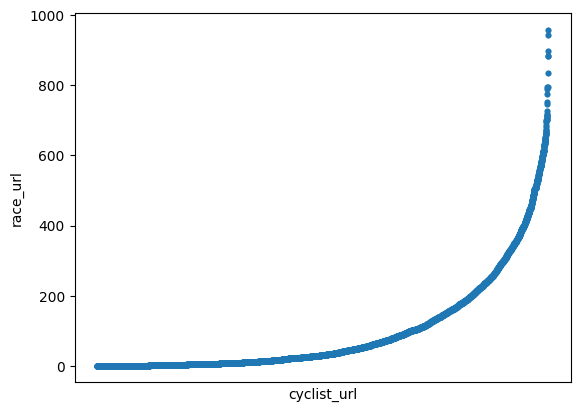

In [21]:
plot = sb.scatterplot(
    data=cyclists,
    x="cyclist_url",
    y="race_url",
    s=20,
    linewidth=0
)

plot.set_xlabel("cyclist_url")
plot.set_xticks([])
plt.show()


### `name` data

In [22]:
# TODO: eliminare sezione 'name' se non serve

### `birth_year` data

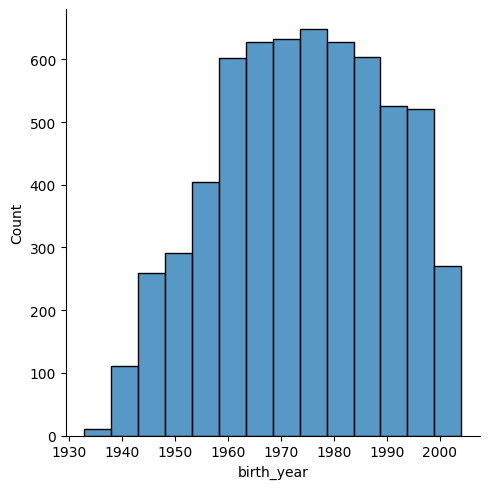

In [23]:
n_bins = math.ceil(math.log2(len(dataset)) + 1)

sb.displot(dataset, 
                x="birth_year", 
                kind="hist",
                row_order="desc",
                bins=n_bins) #TODO: cambia nome dell'asse x

Birth years are of the last century, and are values within the expected range.
Cyclists with the highest representation are those born before 2000, starting from the 1960s.

### `weight` and `height` data

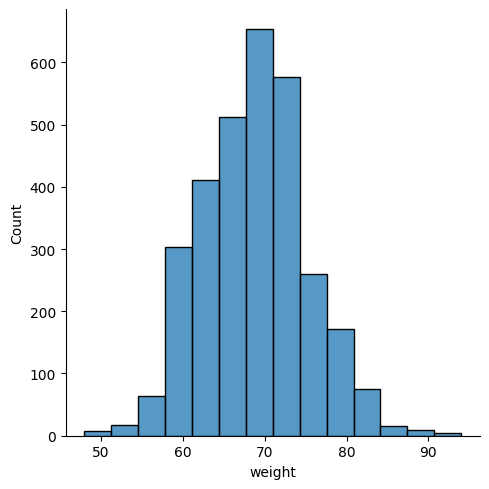

In [24]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

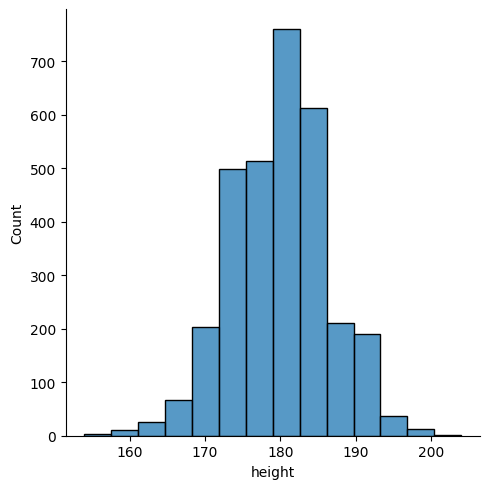

In [25]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

According to the data we collected from sources (cite), the average height of cyclists should be between 175 and 185 cm with a weight ranging from 60 to 70 kg. Our graphs confirm this data with the majority classes for the attributes located around these averages. We can assume that the underrepresentation of higher and lower values is not due to bias in our dataset but rather to the natural statistical distribution of cycling.

### `nationality` data

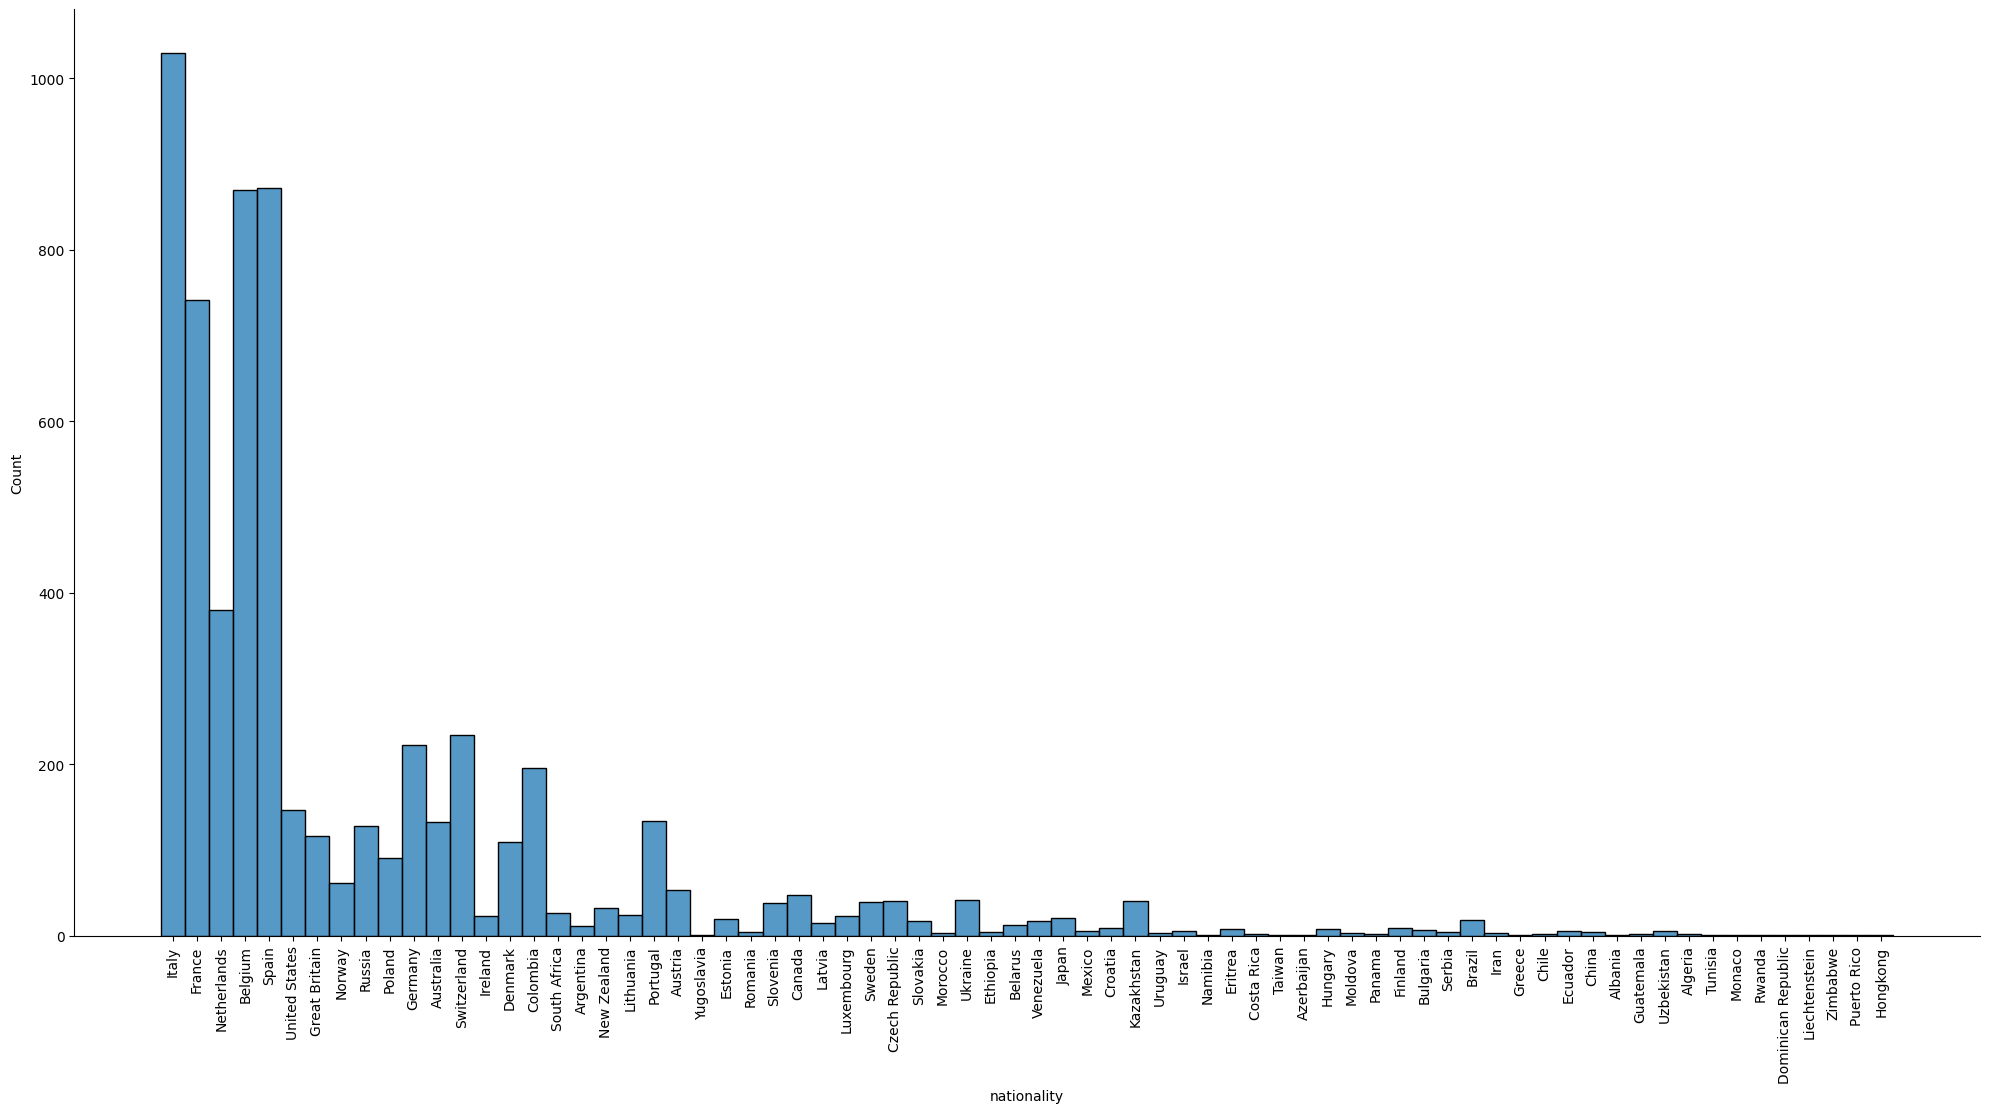

In [26]:
sb.displot(dataset, 
                x="nationality", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['nationality'].unique()),
                height=10,
                aspect=2)
plt.xticks(rotation=90);

Our dataset presents a majority of data for European nationalities.

Plausible reasons:
1. Cycling is a historically more relevant sport in Europe;
2. The most important races are held in Europe:
    * Athletes more passionate about the sport are Europeans;
    * Athletes from countries distant from Europe are less likely to participate in European races;
3. Our dataset presents biases on the nationalities of selected cyclists or the races they participated in.

### Comments on Distributions

Looking at the previous graphs, it is possible to search for the presence of default values that hide gaps in the dataset. We found that the distribution of values is similar to what we would expect; if there had been a default value, its frequency would have been off the scale. From now on, we will consider these attributes as free of default values.

### Further Boxplots

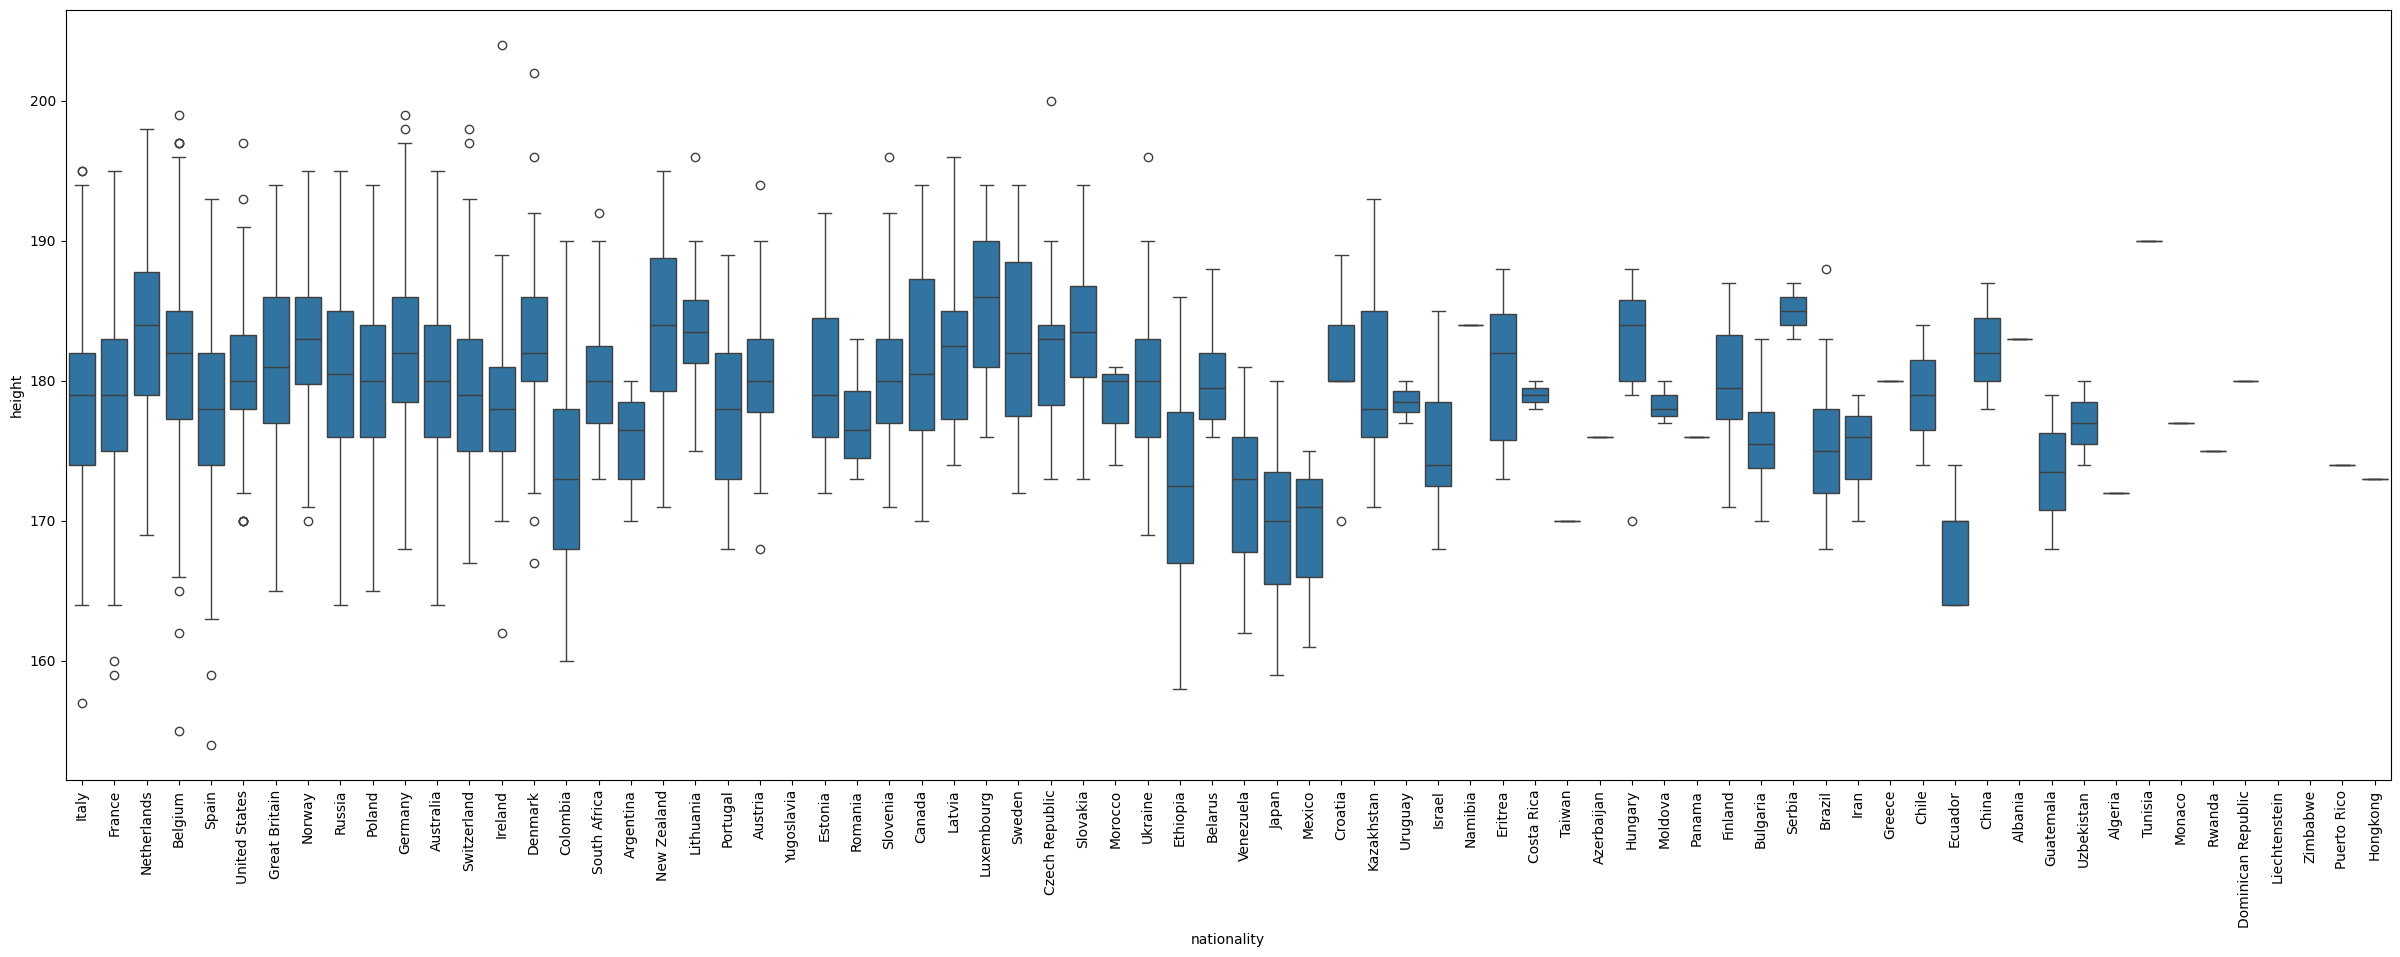

In [27]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='height', data=dataset)
plt.xticks(rotation=90);
plt.show()

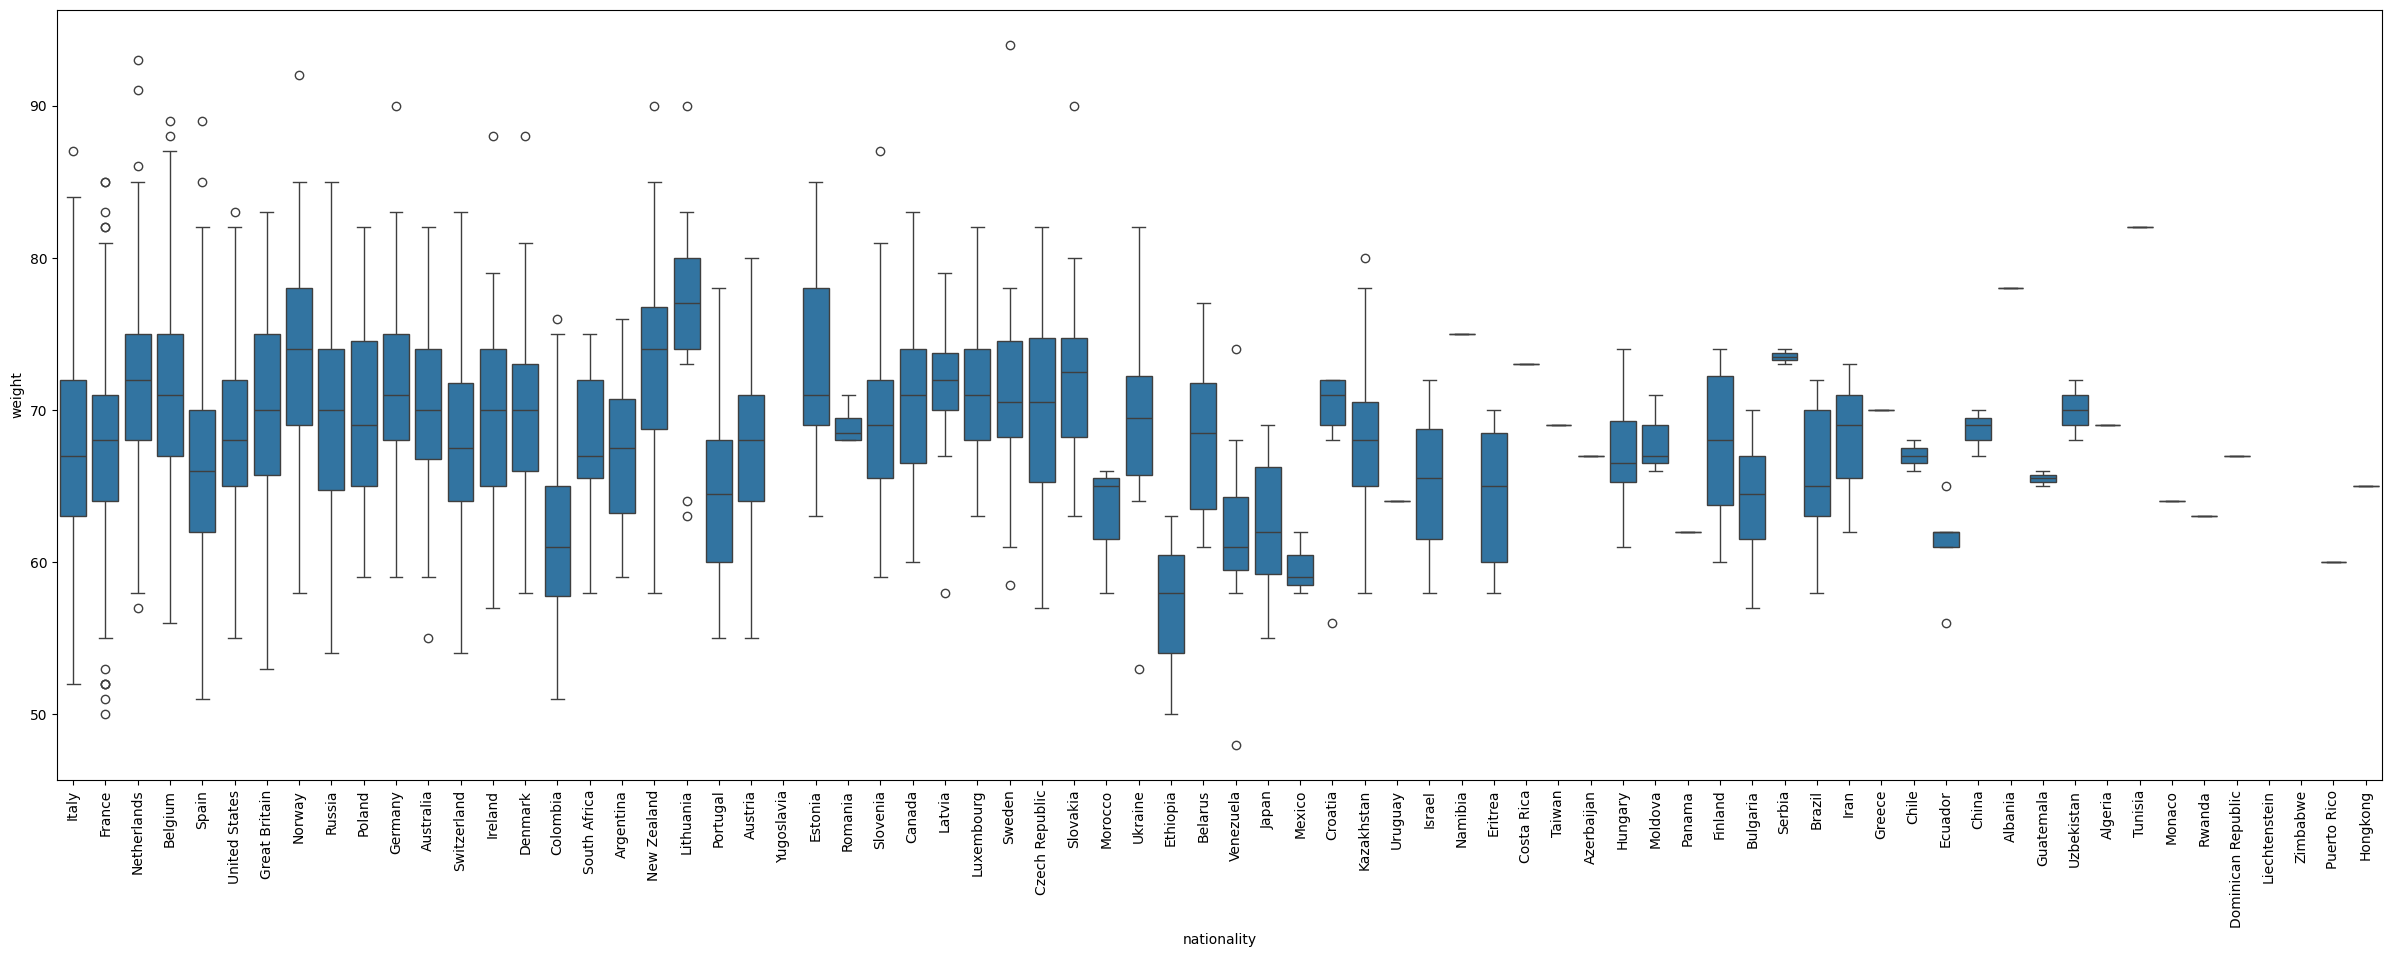

In [28]:
plt.figure(figsize=(30, 10))
sb.boxplot(x='nationality', y='weight', data=dataset)
plt.xticks(rotation=90);
plt.show()

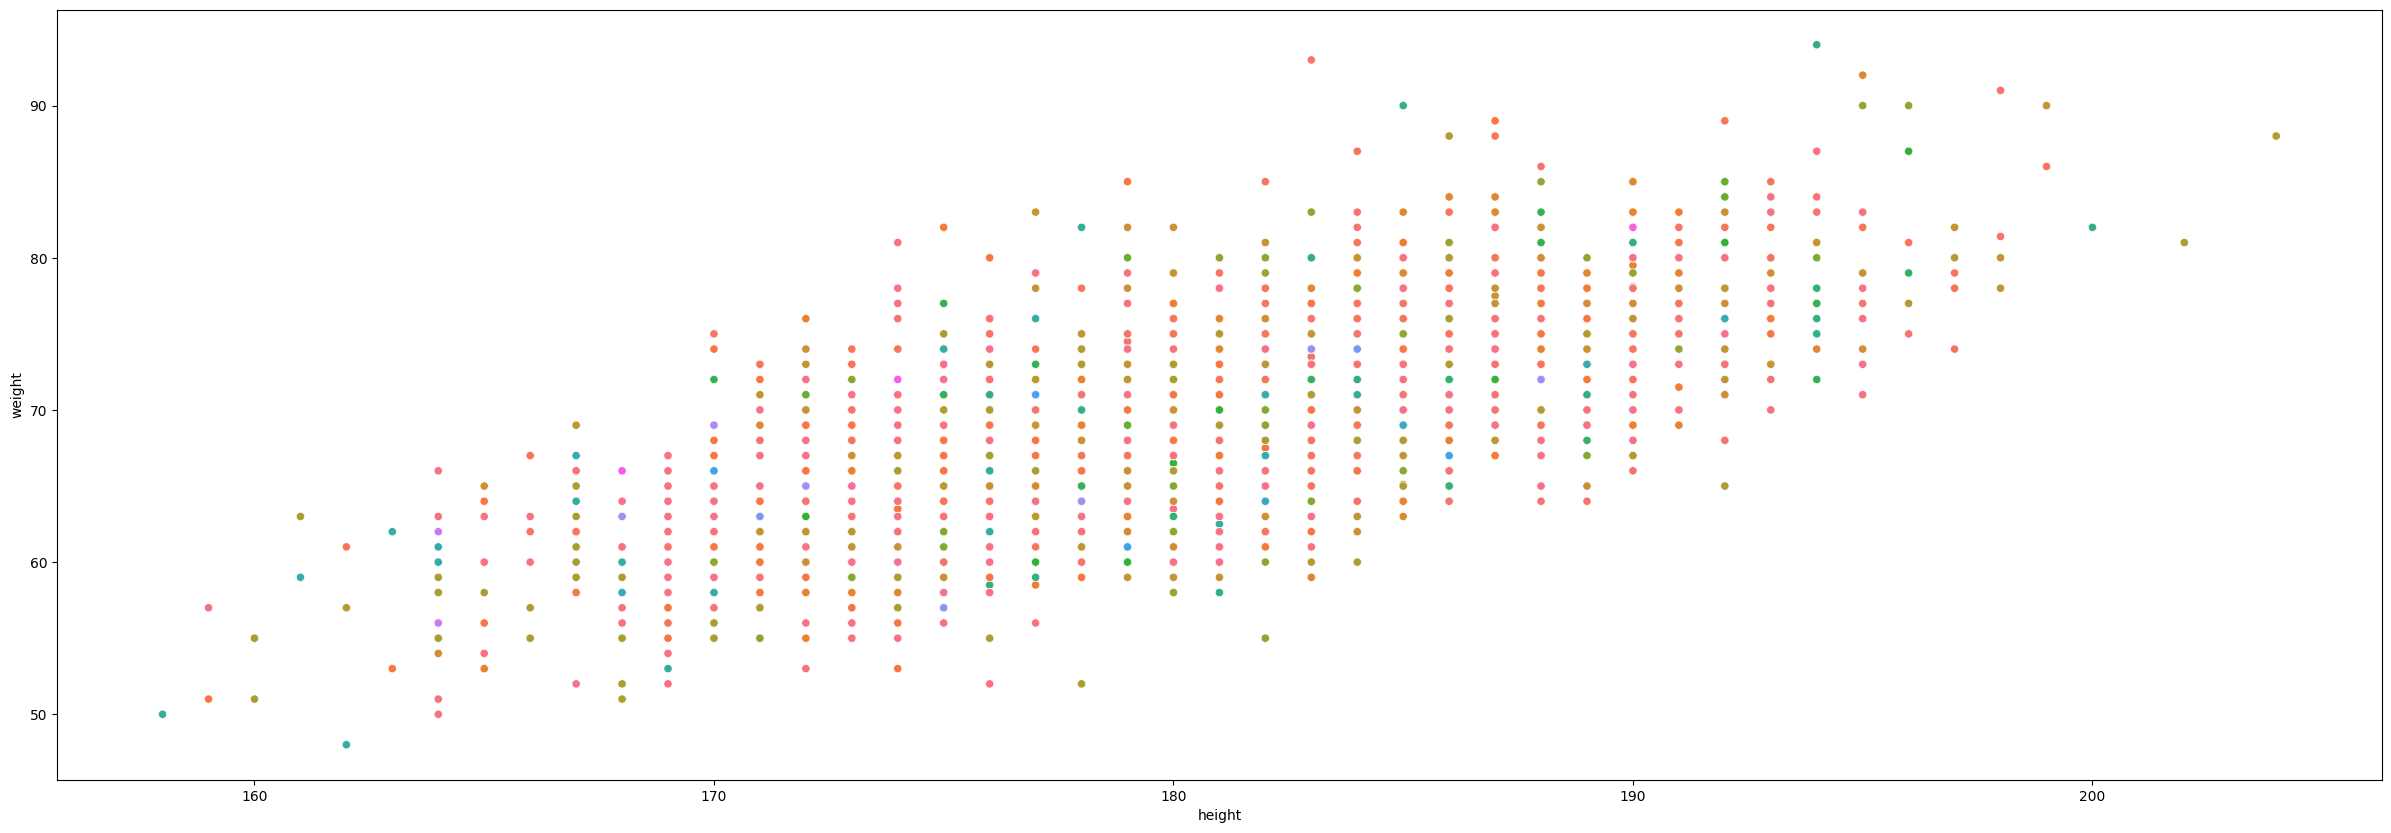

In [29]:
plt.figure(figsize=(30, 10))
sb.scatterplot(x='height', y='weight', data=dataset, hue='nationality')
plt.legend().remove()
plt.show()

From the qualitative analysis of this boxplot, it emerges that distinguishing by nationality, the probabilistic distributions of height and weight attributes are not particularly diversified. The few differences we can notice (e.g., Ecuador compared to China) are not supported by a sufficient number of records (comparison between 5 and 4 cyclists).

The type of imputation we previously hypothesized would therefore not be sufficiently effective and could actually produce "worse" biases compared to other simpler types of imputation (such as statistical imputation). We would therefore proceed by replacing the missing heights and weights with randomly drawn values from the global distribution of the attributes.

### Correlations

In [30]:
normalized_dataset, normalization_scalers_dataset = center_and_scale(dataset)
correlations = correlations(normalized_dataset)
correlations

,birth_year,weight,height,correlation_type
birth_year,1.000000,-0.063740,0.094976,kendall
weight,-0.063740,1.000000,0.539760,kendall
height,0.094976,0.539760,1.000000,kendall
birth_year,1.000000,-0.104242,0.154252,pearson
weight,-0.104242,1.000000,0.720732,pearson
height,0.154252,0.720732,1.000000,pearson
birth_year,1.000000,-0.091220,0.137001,spearman
weight,-0.091220,1.000000,0.705189,spearman
height,0.137001,0.705189,1.000000,spearman


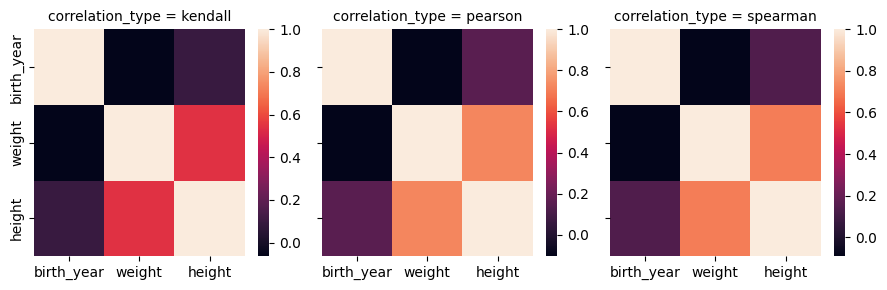

In [31]:
g = sb.FacetGrid(correlations, col="correlation_type")
g.map_dataframe(lambda data, color: sb.heatmap(data[data.columns[:-1]]))

The table shows the correlation coefficients between the cyclists attributes `birth_year`, `weight`, and `height`. The correlations are calculated using three different methods:
- **Kendall**: A non-parametric measure of correlation that assesses the strength and direction of association between two variables.
- **Pearson**: Measures the linear relationship between two variables. It assumes that the data is normally distributed.
- **Spearman**: A non-parametric measure that assesses how well the relationship between two variables can be described using a monotonic function.

For the **Kendall Correlation** we have:
- `birth_year` and `weight`: -0.063740 (weak negative correlation)
- `birth_year` and `height`: 0.094976 (weak positive correlation)
- `weight` and `height`: 0.539760 (moderate positive correlation)

For the Pearson Correlation we have:
- `birth_year` and `weight`: -0.104242 (weak negative correlation)
- `birth_year` and `height`: 0.154252 (weak positive correlation)
- `weight` and `height`: 0.720732 (strong positive correlation)

For the Spearman Correlation we have:
- `birth_year` and `weight`: -0.091220 (weak negative correlation)
- `birth_year` and `height`: 0.137001 (weak positive correlation)
- `weight` and `height`: 0.705189 (strong positive correlation)

So, what are importants are the correlations between `weight` and `height`, that are moderate to strong and positive across all methods, indicating a significant relationship between these two variables.

# SERVE ?

In [32]:
N = len(dataset[dataset['height'].notnull()])
bins = int(1 + 10/3 * math.log10(N))

dataset['height_discretized'] = pd.cut(dataset['height'], bins=bins, labels=[i for i in range(1, bins+1)])

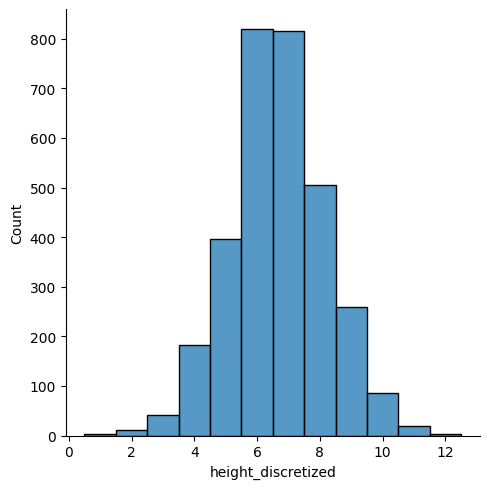

In [33]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

In [34]:
dataset['height_discretized'].value_counts(normalize=True).sort_index()
# probabilità di ogni classe di altezza

height_discretized
1     0.001273
2     0.003818
3     0.013045
4     0.058225
5     0.125994
6     0.260579
7     0.259625
8     0.160675
9     0.082405
10    0.027362
11    0.006045
12    0.000955
Name: proportion, dtype: float64

In [35]:
probabilities = dataset['height_discretized'].value_counts(normalize=True).sort_index().to_list()
classes = [i for i in range(1, bins+1)] # the values to be extracted
random_height_discretized = random.choices(classes, weights=probabilities, k=len(dataset[dataset['height_discretized'].isnull()]))
nan_indices = dataset[dataset['height_discretized'].isna()]['height_discretized'].index

for idx, val in zip(nan_indices, random_height_discretized):
    dataset.at[idx, 'height_discretized'] = val

In [36]:
dataset['height_discretized'].isnull().sum()

np.int64(0)

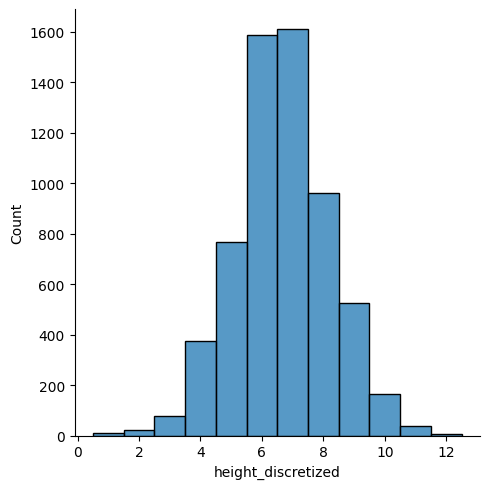

In [37]:
sb.displot(dataset, 
                x="height_discretized", 
                kind="hist",
                row_order="desc",
                bins=len(dataset['height_discretized'].unique()))

Dopo aver sostituito i valori NaN dell'attributo "height_discretized" controlliamo che la distribuzione rimanga pressochè simile a quella originale

In [38]:
mean_heights = dataset[['height', 'height_discretized']].groupby(by='height_discretized', observed=True).mean()['height'] # compute the mean height for each heigt_discretized

def return_mean_height(row):
    return mean_heights[mean_heights.index == row['height_discretized']].iloc[0]

height_to_substitue = dataset[dataset['height'].isnull() & dataset['weight'].isnull()].apply(return_mean_height, axis=1)
dataset.loc[height_to_substitue.index, 'height'] = height_to_substitue.values

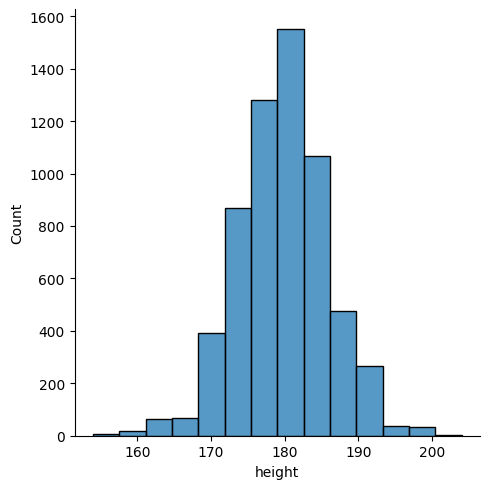

In [39]:
sb.displot(dataset, 
                x="height", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

solito controllo della distribuzione per verificare che sia pressoché simile a quella originale

In [40]:
imputer = KNNImputer(n_neighbors=6) #TODO: controllare bene se vada bene questo valore di n_neighbors

imputed_values = imputer.fit_transform(dataset[['height', 'weight']])
dataset[['height', 'weight']] = imputed_values

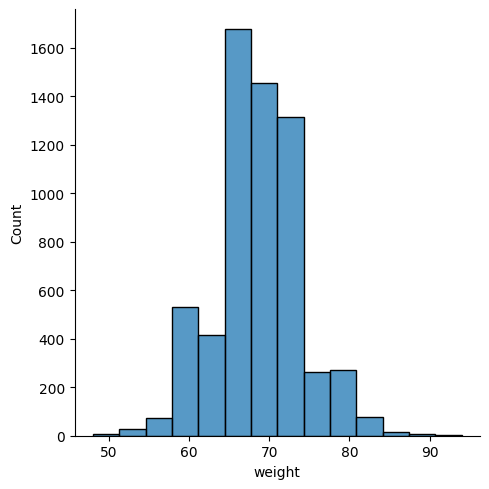

In [41]:
sb.displot(dataset, 
                x="weight", 
                kind="hist",
                row_order="desc",
                bins=n_bins)

per sostituire i valori NaN della feature "weight" abbiamo usato il KNNImputer, utilizzando un numero di vicini che permettesse di mantenere la distribuzione originale